In [1]:
import pandas as pd
import spacy
from spacy.matcher import Matcher
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

Task 1 : Basic Data Exploration using Pandas

Import Dataset

In [2]:
df = pd.read_csv("Real Estate Data V21.csv")

Basic Data Exploration

In [3]:
print("Shape of dataset:", df.shape)           

Shape of dataset: (14528, 9)


In [4]:
print("Columns:", df.columns.tolist())

Columns: ['Name', 'Property Title', 'Price', 'Location', 'Total_Area', 'Price_per_SQFT', 'Description', 'Baths', 'Balcony']


In [5]:
print("Data types:\n", df.dtypes)            

Data types:
 Name               object
Property Title     object
Price              object
Location           object
Total_Area          int64
Price_per_SQFT    float64
Description        object
Baths               int64
Balcony            object
dtype: object


In [6]:
df.head()

,Name,Property Title,Price,Location,Total_Area,Price_per_SQFT,Description,Baths,Balcony
0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",₹1.99 Cr,"Kanathur Reddikuppam, Chennai",2583,7700.0,Best 4 BHK Apartment for modern-day lifestyle ...,4,Yes
1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,₹2.25 Cr,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210.0,Looking for a 10 BHK Independent House for sal...,6,Yes
2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",₹1.0 Cr,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580.0,"Property for sale in Tambaram, Chennai. This 3...",3,No
3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,₹3.33 Cr,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840.0,Entire Building for sale with 7 units of singl...,5,Yes
4,VGN Spring Field Phase 1,"2 BHK Flat for sale in Avadi, Chennai",₹48.0 L,"Avadi, Chennai",960,5000.0,"Property for sale in Avadi, Chennai. This 2 BH...",3,Yes


In [7]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 Name              0
Property Title    0
Price             0
Location          0
Total_Area        0
Price_per_SQFT    0
Description       0
Baths             0
Balcony           0
dtype: int64


In [8]:
print("Duplicate values:\n",df.duplicated().sum())  #gives exact  duplicate rows

Duplicate values:
 8


In [9]:
print("Unique values:\n",df.nunique())

Unique values:
 Name               9998
Property Title     6507
Price               891
Location           7050
Total_Area         1774
Price_per_SQFT     2094
Description       14490
Baths                 6
Balcony               2
dtype: int64


In [10]:
df.describe()

,Total_Area,Price_per_SQFT,Baths
count,14528.000000,14528.000000,14528.000000
mean,1297.916988,11719.456222,2.751239
std,1245.694305,49036.068632,0.898243
min,70.000000,0.000000,1.000000
25%,650.000000,4480.000000,2.000000
50%,1000.000000,6050.000000,3.000000
75%,1439.000000,9312.500000,3.000000
max,35000.000000,999000.000000,6.000000


Task 2: Bedrooms Extraction From Property Title

In [11]:
nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

In [12]:
# digit + (optional '+') + bhk/bedroom(s)
pattern1 = [
    {"LIKE_NUM": True},
    {"IS_PUNCT": True, "OP": "?"},
    {"LOWER": {"IN": ["bhk", "bedroom", "bedrooms"]}}
]

# written number + bhk/bedroom(s)
pattern2 = [
    {"LOWER": {"IN": [
        "one","two","three","four","five","six","seven","eight","nine","ten"
    ]}},
    {"LOWER": {"IN": ["bhk","bedroom","bedrooms"]}}
]

# RK case
pattern3 = [{"LIKE_NUM": True, "OP": "?"}, {"LOWER": "rk"}]

matcher.add("ROOMS", [pattern1, pattern2, pattern3])


In [13]:
def extract_rooms(text):
    text = str(text).lower()
    doc = nlp(text)
    matches = matcher(doc)

    bedrooms = 0
    hall = 0
    kitchen = 0
    bhk_or_rk = None

    for match_id, start, end in matches:
        span = doc[start:end]
        first_token = span[0]

        # Case 1: "5 BHK" / "5+ BHK"
        if "bhk" in span.text:
            val = None
            if first_token.like_num:
                val = int(re.sub(r"\D", "", first_token.text))  # 5+
            elif first_token.text in word_to_num:
                val = word_to_num[first_token.text]

            if val:
                bedrooms = val
                hall = 1
                kitchen = 1
                bhk_or_rk = "BHK"

        # Case 2: "2 bedrooms"
        elif "bedroom" in span.text:
            val = None
            if first_token.like_num:
                val = int(re.sub(r"\D", "", first_token.text))
            elif first_token.text in word_to_num:
                val = word_to_num[first_token.text]
            if val:
                bedrooms = val
                bhk_or_rk = "BHK"

        # Case 3: "RK"
        elif "rk" in span.text:
            bhk_or_rk = "RK"
            bedrooms = 0
            hall = 0
            kitchen = 1

    total_rooms = bedrooms + hall + kitchen
    return pd.Series([bedrooms, hall, kitchen, total_rooms, bhk_or_rk],
                     index=["Bedrooms", "Hall", "Kitchen", "Total_Rooms", "BHK_or_RK"])



In [14]:
df[["Bedrooms", "Hall", "Kitchen", "Total_Rooms", "BHK_or_RK"]] = df["Property Title"].apply(extract_rooms)

In [15]:
print(df[["Property Title", "Bedrooms", "Hall", "Kitchen", "Total_Rooms", "BHK_or_RK"]].head(20))

                                       Property Title  Bedrooms  Hall  \
0   4 BHK Flat for sale in Kanathur Reddikuppam, C...       4.0   1.0   
1   10 BHK Independent House for sale in Pozhichal...      10.0   1.0   
2       3 BHK Flat for sale in West Tambaram, Chennai       3.0   1.0   
3   7 BHK Independent House for sale in Triplicane...       7.0   1.0   
4               2 BHK Flat for sale in Avadi, Chennai       2.0   1.0   
5            2 BHK Flat for sale in Siruseri, Chennai       2.0   1.0   
6           2 BHK Flat for sale in Sembakkam, Chennai       2.0   1.0   
7   3 BHK Independent House for sale in Mahindra W...       3.0   1.0   
8       2 BHK Flat for sale in West Tambaram, Chennai       2.0   1.0   
9           1 BHK Flat for sale in Chromepet, Chennai       1.0   1.0   
10  1 BHK Flat for sale in Mahindra World City, Ch...       1.0   1.0   
11       3 BHK Flat for sale in Pallikaranai, Chennai       3.0   1.0   
12     6 BHK Villa for sale in West Mambalam, Chenn

In [16]:
df.head()

,Name,Property Title,Price,Location,Total_Area,Price_per_SQFT,Description,Baths,Balcony,Bedrooms,Hall,Kitchen,Total_Rooms,BHK_or_RK
0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",₹1.99 Cr,"Kanathur Reddikuppam, Chennai",2583,7700.0,Best 4 BHK Apartment for modern-day lifestyle ...,4,Yes,4.0,1.0,1.0,6.0,BHK
1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,₹2.25 Cr,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210.0,Looking for a 10 BHK Independent House for sal...,6,Yes,10.0,1.0,1.0,12.0,BHK
2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",₹1.0 Cr,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580.0,"Property for sale in Tambaram, Chennai. This 3...",3,No,3.0,1.0,1.0,5.0,BHK
3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,₹3.33 Cr,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840.0,Entire Building for sale with 7 units of singl...,5,Yes,7.0,1.0,1.0,9.0,BHK
4,VGN Spring Field Phase 1,"2 BHK Flat for sale in Avadi, Chennai",₹48.0 L,"Avadi, Chennai",960,5000.0,"Property for sale in Avadi, Chennai. This 2 BH...",3,Yes,2.0,1.0,1.0,4.0,BHK


EDA

In [17]:
def convert_price(price_str):
    price_str = str(price_str).replace(",", "").strip()
    
    # Match numbers with optional decimals + units like L, Lakh, Cr, etc.
    match = re.match(r'₹?\s*([\d]+(?:\.\d+)?)\s*(L|Cr|Crore|Crores)?', price_str, re.IGNORECASE)
    
    if match:
        value = float(match.group(1))   # numeric part
        unit = match.group(2)           # unit part
        
        if unit:
            unit = unit.lower()
            if unit in ["l", "lakh", "lakhs"]:
                return value * 1e5   # 1 Lakh = 100,000
            elif unit in ["cr", "crore", "crores"]:
                return value * 1e7   # 1 Cr = 10,000,000
        return value  # no unit → raw number
    return None

In [18]:
df["Price_Num"] = df["Price"].apply(convert_price)

In [19]:
df.head()

,Name,Property Title,Price,Location,Total_Area,Price_per_SQFT,Description,Baths,Balcony,Bedrooms,Hall,Kitchen,Total_Rooms,BHK_or_RK,Price_Num
0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",₹1.99 Cr,"Kanathur Reddikuppam, Chennai",2583,7700.0,Best 4 BHK Apartment for modern-day lifestyle ...,4,Yes,4.0,1.0,1.0,6.0,BHK,19900000.0
1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,₹2.25 Cr,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210.0,Looking for a 10 BHK Independent House for sal...,6,Yes,10.0,1.0,1.0,12.0,BHK,22500000.0
2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",₹1.0 Cr,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580.0,"Property for sale in Tambaram, Chennai. This 3...",3,No,3.0,1.0,1.0,5.0,BHK,10000000.0
3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,₹3.33 Cr,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840.0,Entire Building for sale with 7 units of singl...,5,Yes,7.0,1.0,1.0,9.0,BHK,33300000.0
4,VGN Spring Field Phase 1,"2 BHK Flat for sale in Avadi, Chennai",₹48.0 L,"Avadi, Chennai",960,5000.0,"Property for sale in Avadi, Chennai. This 2 BH...",3,Yes,2.0,1.0,1.0,4.0,BHK,4800000.0


In [20]:
df["Balcony_Flag"] = df["Balcony"].apply(lambda x: 0 if str(x).lower().strip() in ["no", "no balcony", "-", "na"] else 1)

In [21]:
df.head()

,Name,Property Title,Price,Location,Total_Area,Price_per_SQFT,Description,Baths,Balcony,Bedrooms,Hall,Kitchen,Total_Rooms,BHK_or_RK,Price_Num,Balcony_Flag
0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",₹1.99 Cr,"Kanathur Reddikuppam, Chennai",2583,7700.0,Best 4 BHK Apartment for modern-day lifestyle ...,4,Yes,4.0,1.0,1.0,6.0,BHK,19900000.0,1
1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,₹2.25 Cr,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210.0,Looking for a 10 BHK Independent House for sal...,6,Yes,10.0,1.0,1.0,12.0,BHK,22500000.0,1
2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",₹1.0 Cr,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580.0,"Property for sale in Tambaram, Chennai. This 3...",3,No,3.0,1.0,1.0,5.0,BHK,10000000.0,0
3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,₹3.33 Cr,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840.0,Entire Building for sale with 7 units of singl...,5,Yes,7.0,1.0,1.0,9.0,BHK,33300000.0,1
4,VGN Spring Field Phase 1,"2 BHK Flat for sale in Avadi, Chennai",₹48.0 L,"Avadi, Chennai",960,5000.0,"Property for sale in Avadi, Chennai. This 2 BH...",3,Yes,2.0,1.0,1.0,4.0,BHK,4800000.0,1


In [22]:
df.head()

,Name,Property Title,Price,Location,Total_Area,Price_per_SQFT,Description,Baths,Balcony,Bedrooms,Hall,Kitchen,Total_Rooms,BHK_or_RK,Price_Num,Balcony_Flag
0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",₹1.99 Cr,"Kanathur Reddikuppam, Chennai",2583,7700.0,Best 4 BHK Apartment for modern-day lifestyle ...,4,Yes,4.0,1.0,1.0,6.0,BHK,19900000.0,1
1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,₹2.25 Cr,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210.0,Looking for a 10 BHK Independent House for sal...,6,Yes,10.0,1.0,1.0,12.0,BHK,22500000.0,1
2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",₹1.0 Cr,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580.0,"Property for sale in Tambaram, Chennai. This 3...",3,No,3.0,1.0,1.0,5.0,BHK,10000000.0,0
3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,₹3.33 Cr,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840.0,Entire Building for sale with 7 units of singl...,5,Yes,7.0,1.0,1.0,9.0,BHK,33300000.0,1
4,VGN Spring Field Phase 1,"2 BHK Flat for sale in Avadi, Chennai",₹48.0 L,"Avadi, Chennai",960,5000.0,"Property for sale in Avadi, Chennai. This 2 BH...",3,Yes,2.0,1.0,1.0,4.0,BHK,4800000.0,1


Task 3 : EDA

In [23]:
sns.set(style="whitegrid", palette="muted")

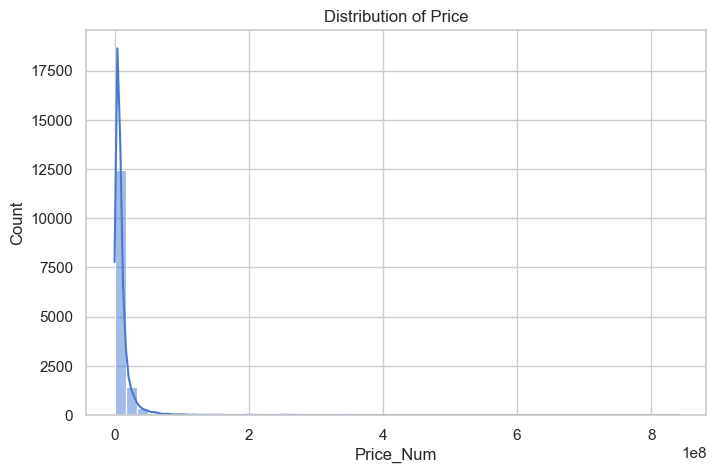

In [24]:
# 1. Price Distribution
plt.figure(figsize=(8,5))
sns.histplot(df["Price_Num"].dropna(), bins=50, kde=True)
plt.title("Distribution of Price")
plt.show()

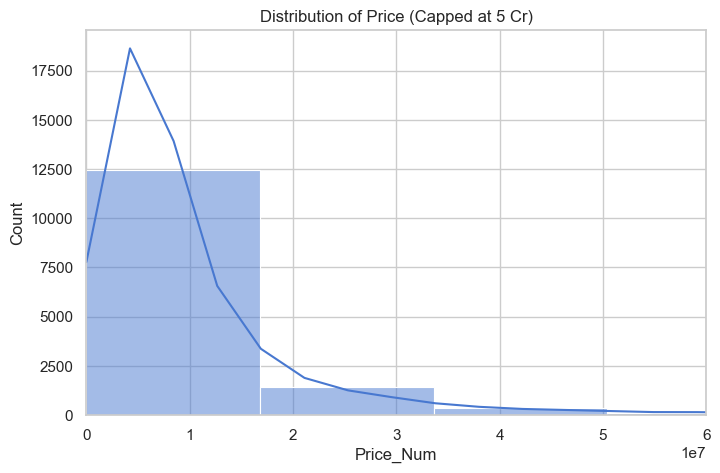

In [25]:
plt.figure(figsize=(8,5))
sns.histplot(df["Price_Num"].dropna(), bins=50, kde=True)
plt.xlim(0, 6e7) # limit to 5 Cr = 50,000,000
plt.title("Distribution of Price (Capped at 5 Cr)")
plt.show()

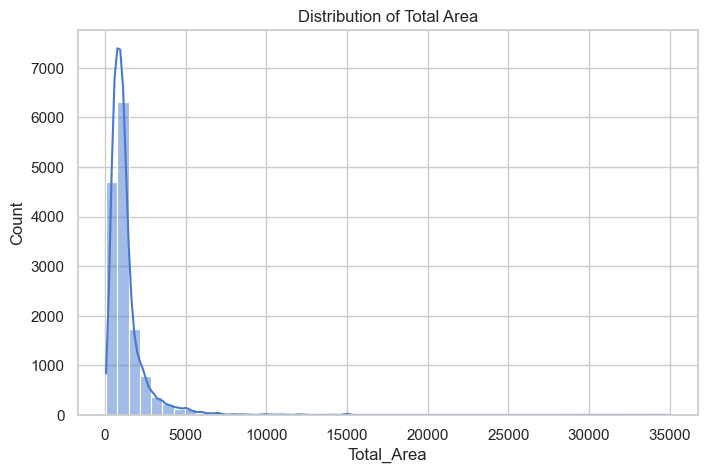

In [26]:
# 2. Total Area Distribution
plt.figure(figsize=(8,5))
sns.histplot(df["Total_Area"], bins=50, kde=True)
plt.title("Distribution of Total Area")
plt.show()

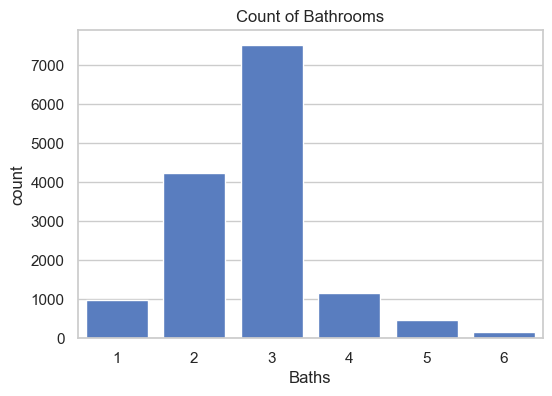

In [27]:
# 4. Bathrooms Count
plt.figure(figsize=(6,4))
sns.countplot(x="Baths", data=df)
plt.title("Count of Bathrooms")
plt.show()

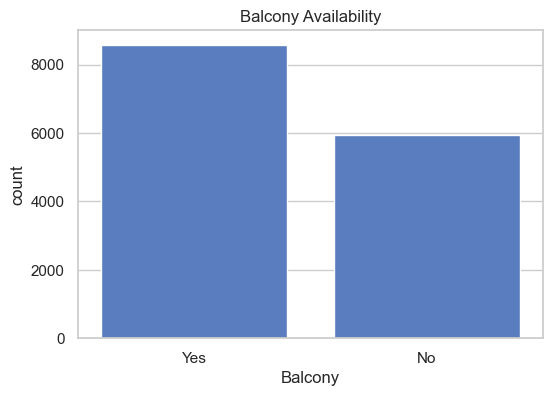

In [28]:
plt.figure(figsize=(6,4))
sns.countplot(x="Balcony", data=df)
plt.title("Balcony Availability")
plt.show()

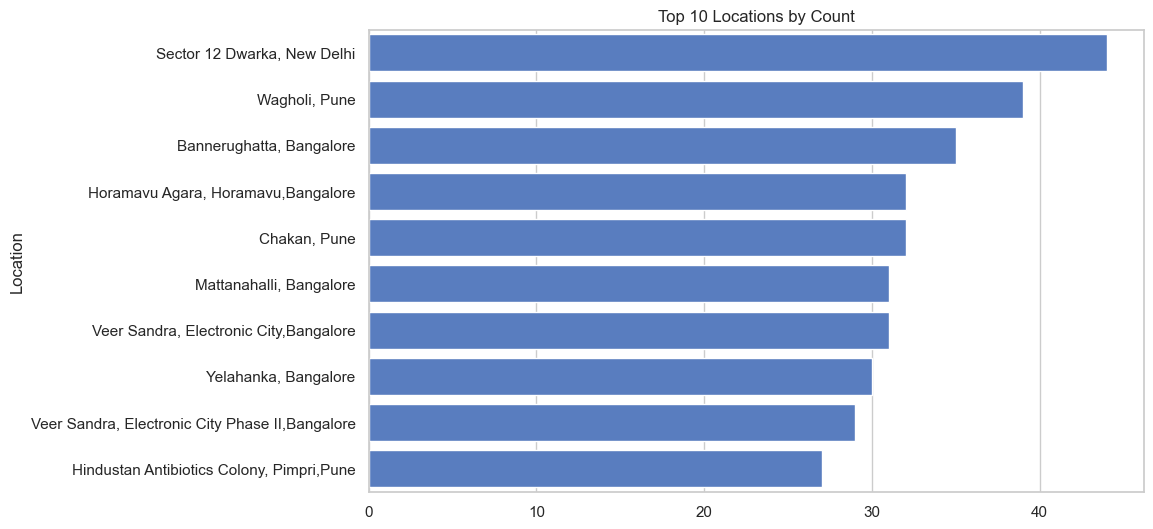

In [29]:
# Top 10 locations
plt.figure(figsize=(10,6))
top_locations = df["Location"].value_counts().nlargest(10)
sns.barplot(x=top_locations.values, y=top_locations.index)
plt.title("Top 10 Locations by Count")
plt.show()

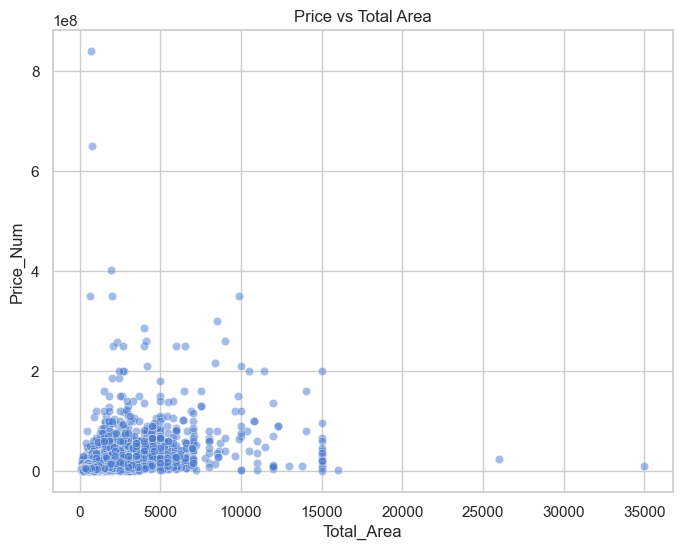

In [30]:
# 1. Price vs Total Area
plt.figure(figsize=(8,6))
sns.scatterplot(x="Total_Area", y="Price_Num", data=df, alpha=0.5)
plt.title("Price vs Total Area")
plt.show()

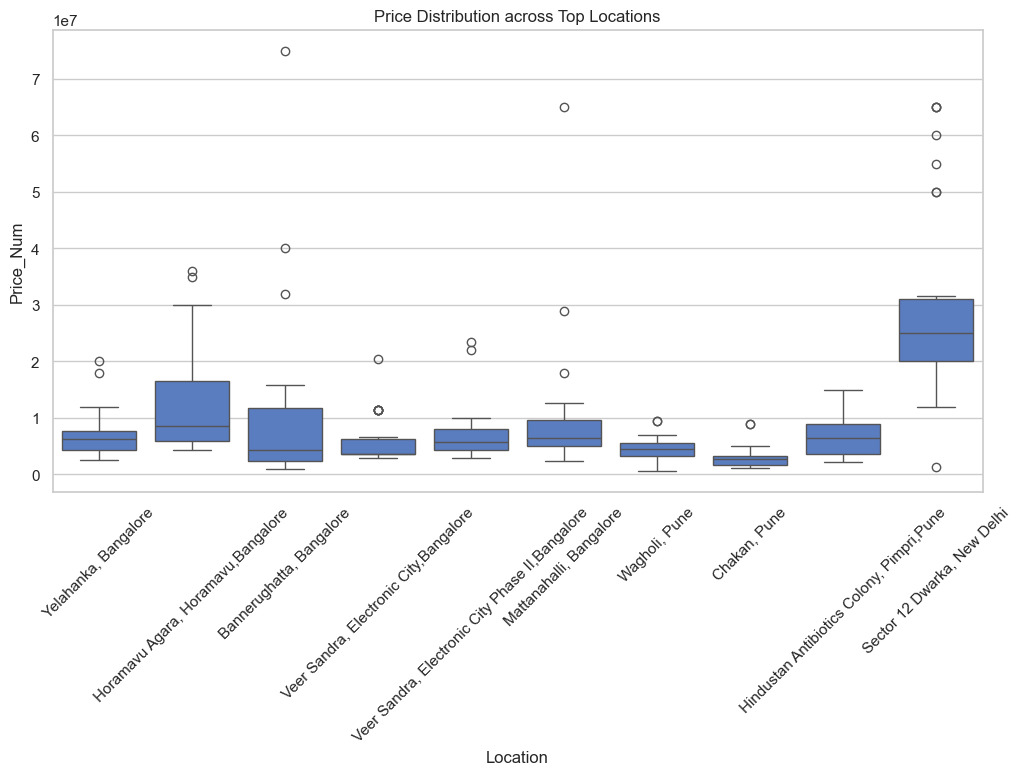

In [31]:
# 2. Price vs Location (Top 10)
plt.figure(figsize=(12,6))
top_loc_df = df[df["Location"].isin(top_locations.index)]
sns.boxplot(x="Location", y="Price_Num", data=top_loc_df)
plt.xticks(rotation=45)
plt.title("Price Distribution across Top Locations")
plt.show()

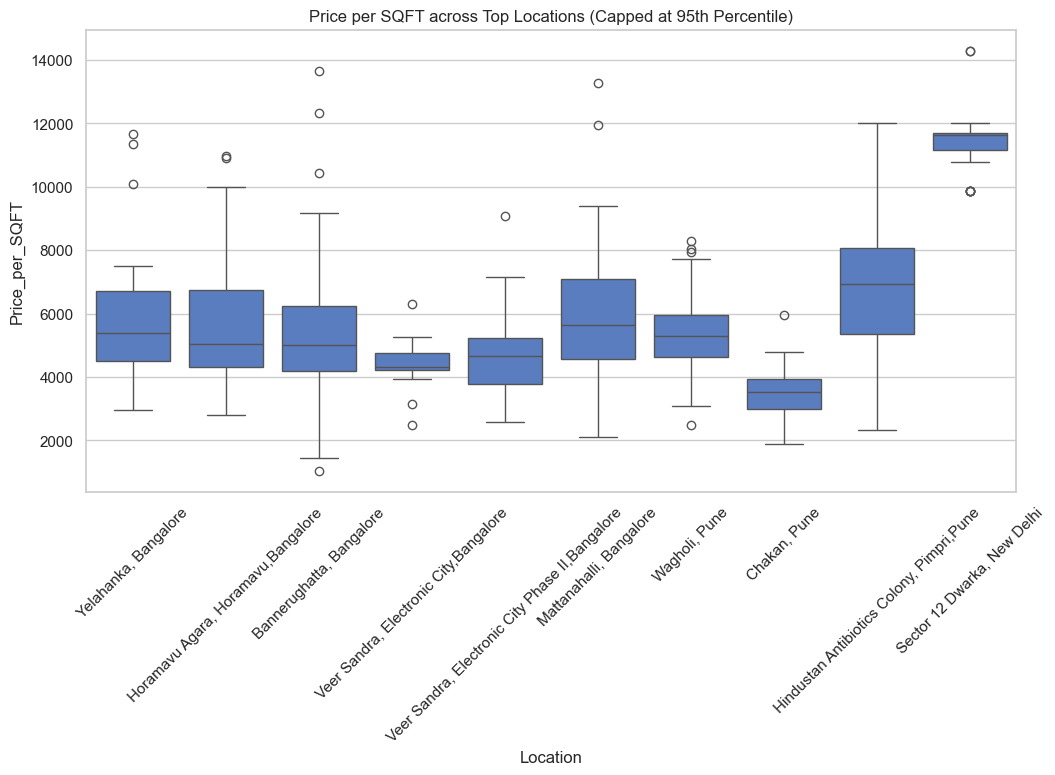

In [32]:
p95 = top_loc_df["Price_per_SQFT"].quantile(0.95)
filtered = top_loc_df[top_loc_df["Price_per_SQFT"] <= p95]

plt.figure(figsize=(12,6))
sns.boxplot(x="Location", y="Price_per_SQFT", data=filtered)
plt.xticks(rotation=45)
plt.title("Price per SQFT across Top Locations (Capped at 95th Percentile)")
plt.show()

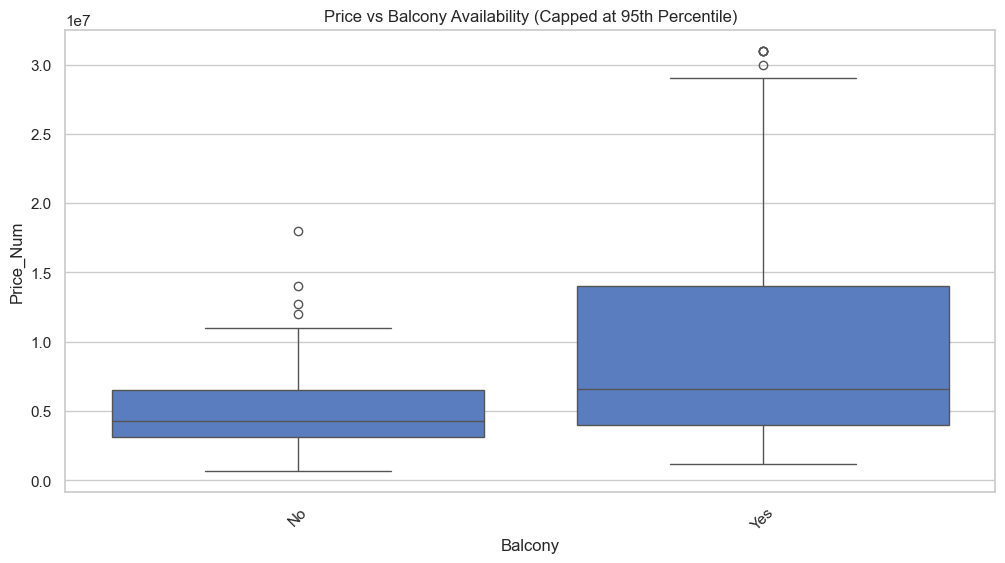

In [33]:
p95 = top_loc_df["Price_Num"].quantile(0.95)
filtered = top_loc_df[top_loc_df["Price_Num"] <= p95]

plt.figure(figsize=(12,6))
sns.boxplot(x="Balcony", y="Price_Num", data=filtered)
plt.xticks(rotation=45)
plt.title("Price vs Balcony Availability (Capped at 95th Percentile)")
plt.show()

In [34]:
df.isnull().sum()

Name               0
Property Title     0
Price              0
Location           0
Total_Area         0
Price_per_SQFT     0
Description        0
Baths              0
Balcony            0
Bedrooms           0
Hall               0
Kitchen            0
Total_Rooms        0
BHK_or_RK         45
Price_Num          0
Balcony_Flag       0
dtype: int64

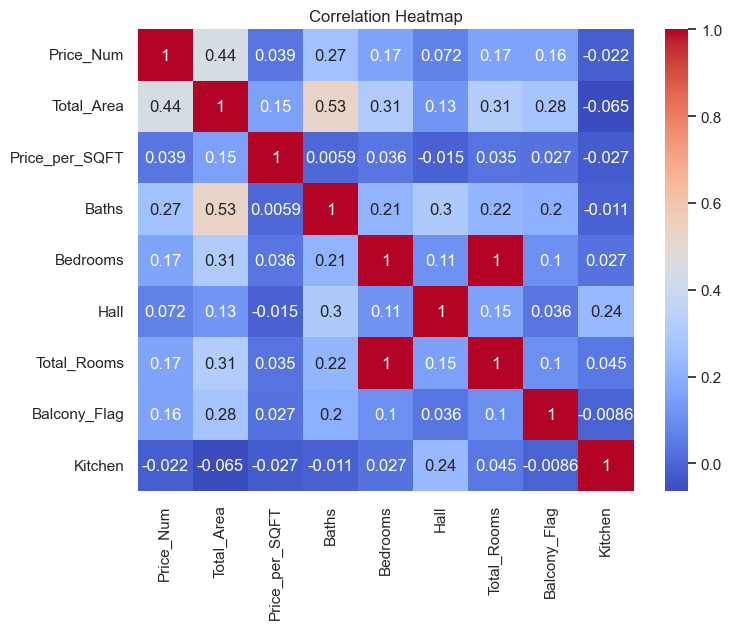

In [35]:
plt.figure(figsize=(8,6))
sns.heatmap(df[["Price_Num","Total_Area","Price_per_SQFT","Baths","Bedrooms","Hall","Total_Rooms","Balcony_Flag","Kitchen"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [37]:
corr = df.corr(numeric_only=True)
print(corr["Price_Num"].sort_values(ascending=False))

Price_Num         1.000000
Total_Area        0.439543
Baths             0.267255
Total_Rooms       0.166893
Bedrooms          0.165342
Balcony_Flag      0.160688
Hall              0.071898
Price_per_SQFT    0.038792
Kitchen          -0.022395
Name: Price_Num, dtype: float64


In [38]:
# Calculate IQR for Price_Num
Q1 = df["Price_Num"].quantile(0.25)
Q3 = df["Price_Num"].quantile(0.75)
IQR = Q3 - Q1

# Outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1 (25th percentile):", Q1)
print("Q3 (75th percentile):", Q3)
print("IQR:", IQR)
print("Lower Bound (below this = outlier):", lower_bound)
print("Upper Bound (above this = outlier):", upper_bound)

# How many outliers
print("Outliers below lower bound:", (df["Price_Num"] < lower_bound).sum())
print("Outliers above upper bound:", (df["Price_Num"] > upper_bound).sum())

Q1 (25th percentile): 3700000.0
Q3 (75th percentile): 11399999.999999998
IQR: 7699999.999999998
Lower Bound (below this = outlier): -7849999.999999996
Upper Bound (above this = outlier): 22949999.999999993
Outliers below lower bound: 0
Outliers above upper bound: 1291


In [39]:
# Calculate IQR for Total_Area
Q1 = df["Total_Area"].quantile(0.25)
Q3 = df["Total_Area"].quantile(0.75)
IQR = Q3 - Q1

# Outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1 (25th percentile):", Q1)
print("Q3 (75th percentile):", Q3)
print("IQR:", IQR)
print("Lower Bound (below this = outlier):", lower_bound)
print("Upper Bound (above this = outlier):", upper_bound)

# How many outliers
print("Outliers below lower bound:", (df["Total_Area"] < lower_bound).sum())
print("Outliers above upper bound:", (df["Total_Area"] > upper_bound).sum())

Q1 (25th percentile): 650.0
Q3 (75th percentile): 1439.0
IQR: 789.0
Lower Bound (below this = outlier): -533.5
Upper Bound (above this = outlier): 2622.5
Outliers below lower bound: 0
Outliers above upper bound: 1162


Price_Num: 1291 outliers detected


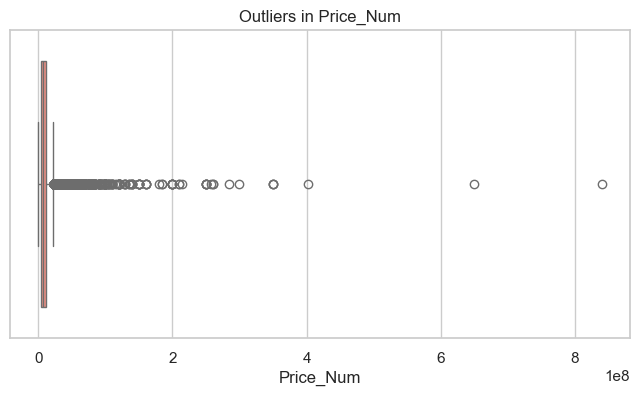

Total_Area: 1162 outliers detected


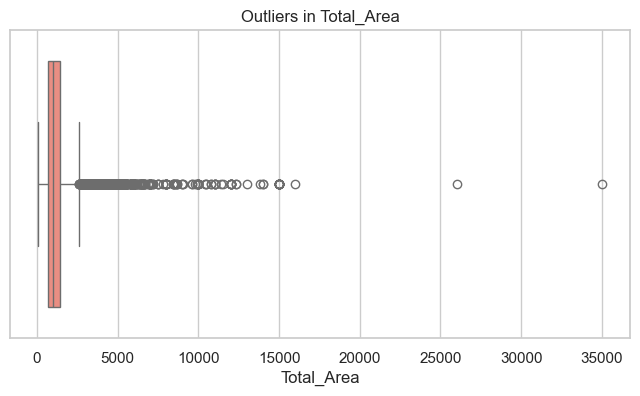

In [40]:
def detect_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[column] < (Q1 - 1.5*IQR)) | (df[column] > (Q3 + 1.5*IQR))]
    print(f"{column}: {outliers.shape[0]} outliers detected")

for col in ["Price_Num", "Total_Area"]:
    detect_outliers(col)
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col], color="salmon")
    plt.title(f"Outliers in {col}")
    plt.show()

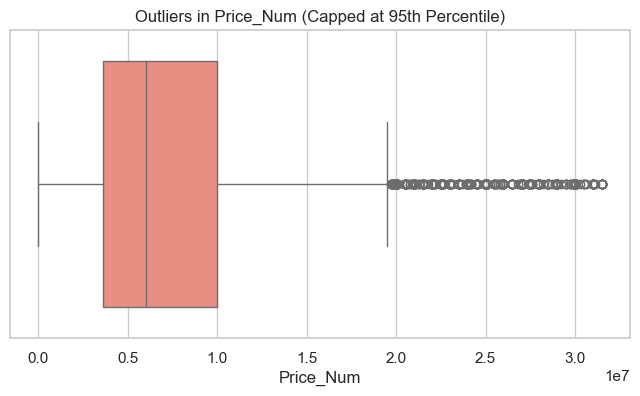

In [41]:
p95 = df["Price_Num"].quantile(0.95)
filtered = df[df["Price_Num"] <= p95]

plt.figure(figsize=(8,4))
sns.boxplot(x=filtered["Price_Num"], color="salmon")
plt.title("Outliers in Price_Num (Capped at 95th Percentile)")
plt.show()


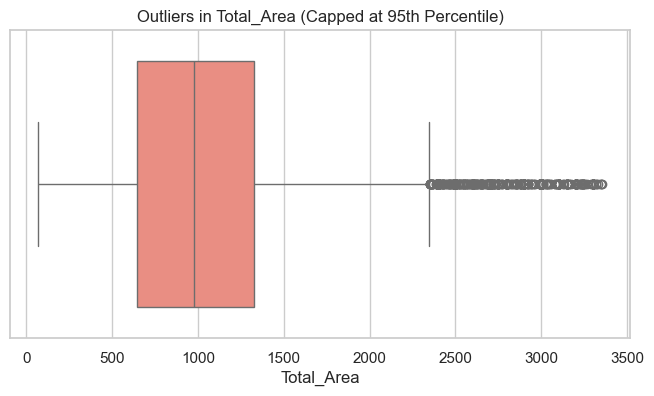

In [42]:
p95 = df["Total_Area"].quantile(0.95)
filtered = df[df["Total_Area"] <= p95]

plt.figure(figsize=(8,4))
sns.boxplot(x=filtered["Total_Area"], color="salmon")
plt.title("Outliers in Total_Area (Capped at 95th Percentile)")
plt.show()

Task 4 :  Creating Base Model, Evaluating its performance

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [44]:
df.isnull().sum()

Name               0
Property Title     0
Price              0
Location           0
Total_Area         0
Price_per_SQFT     0
Description        0
Baths              0
Balcony            0
Bedrooms           0
Hall               0
Kitchen            0
Total_Rooms        0
BHK_or_RK         45
Price_Num          0
Balcony_Flag       0
dtype: int64

In [45]:
selected_features = ["Total_Area", "Baths", "Balcony_Flag","Total_Rooms","Bedrooms","Hall"]

X = df[selected_features]
y = df["Price_Num"]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [47]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [48]:
y_pred = lr.predict(X_test)

In [49]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [50]:
print("Base Model Performance (Linear Regression):")
print("MAE  :", mae)
print("MSE  :", mse)
print("RMSE :", rmse)
print("R²   :", r2)

Base Model Performance (Linear Regression):
MAE  : 5736620.245408734
MSE  : 142639109010349.28
RMSE : 11943161.600277763
R²   : 0.2723328075365352
